<b> The following analysis explores different machine learning methods with the intent to complement conventional methods for assessing the market value of residential real estate in Boston. The Boston Housing Study, with 506 observations, will be used to evaluate different regression modeling techniques within a cross-validation design. All observations will be used, the median value of homes in thousands of 1970 dollars will be used as the response variable, and all explanatory variables will be used with the exception of neighborhood. </b>

In [1]:
# code from jump-start-boston-housing-v001.py
# import base packages
import numpy as np
import pandas as pd

# modeling routines from Scikit Learn packages
import sklearn.linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
import seaborn as sns  
from pandas.plotting import scatter_matrix 
from math import sqrt  

# seed value for random number generators to obtain reproducible results
RANDOM_SEED = 1

# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# ten-fold cross-validation 
N_FOLDS = 10

# read data for the Boston Housing Study
# creating data frame restdata
boston_input = pd.read_csv('boston.csv')

In [2]:
# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
print(boston_input.head())
print(boston_input.tail())


boston DataFrame (first and last five rows):
  neighborhood     crim    zn  indus  chas    nox  rooms   age     dis  rad  \
0       Nahant  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1   
1   Swampscott  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2   
2   Swanpscott  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2   
3   Marblehead  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3   
4   Marblehead  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3   

   tax  ptratio  lstat    mv  
0  296     15.3   4.98  24.0  
1  242     17.8   9.14  21.6  
2  242     17.8   4.03  34.7  
3  222     18.7   2.94  33.4  
4  222     18.7   5.33  36.2  
    neighborhood     crim   zn  indus  chas    nox  rooms   age     dis  rad  \
501     Winthrop  0.06263  0.0  11.93     0  0.573  6.593  69.1  2.4786    1   
502     Winthrop  0.04527  0.0  11.93     0  0.573  6.120  76.7  2.2875    1   
503     Winthrop  0.06076  0.0  11.93     0  0.573  6

In [3]:
# Review DataFrame info
print('\nGeneral description of the boston_input DataFrame:')
print(boston_input.info())


General description of the boston_input DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
neighborhood    506 non-null object
crim            506 non-null float64
zn              506 non-null float64
indus           506 non-null float64
chas            506 non-null int64
nox             506 non-null float64
rooms           506 non-null float64
age             506 non-null float64
dis             506 non-null float64
rad             506 non-null int64
tax             506 non-null int64
ptratio         506 non-null float64
lstat           506 non-null float64
mv              506 non-null float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.4+ KB
None


In [4]:
# drop neighborhood from the data
boston = boston_input.drop('neighborhood', 1)
print('\nGeneral description of the boston DataFrame:')
print(boston.info())


General description of the boston DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rooms      506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
lstat      506 non-null float64
mv         506 non-null float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB
None


In [5]:
print('\nDescriptive statistics of the boston DataFrame:')
print(boston.describe())


Descriptive statistics of the boston DataFrame:
             crim          zn       indus        chas         nox       rooms  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677082   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              age         dis         rad         tax     ptratio       lstat  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.

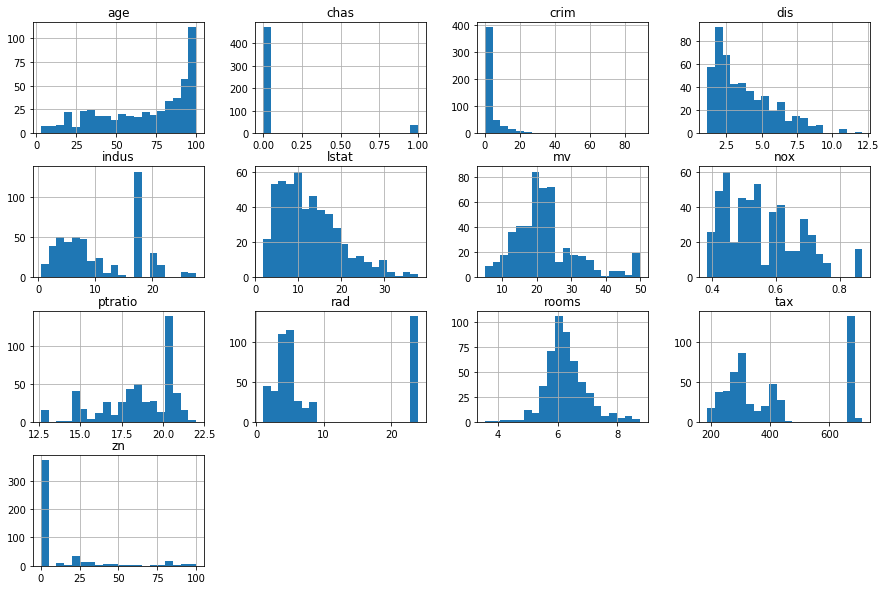

In [6]:
#histograms to visualize the data
import matplotlib.pyplot as plt 
boston.hist(bins = 20, figsize =( 15,10)) 
plt.show()

- The histograms show some skewness in the variables including a left skew for age and right skew for crim, dis, and lstat
- The histograms show the data may contain outliers, especially with indus, rad, and tax variables

<Figure size 432x288 with 0 Axes>

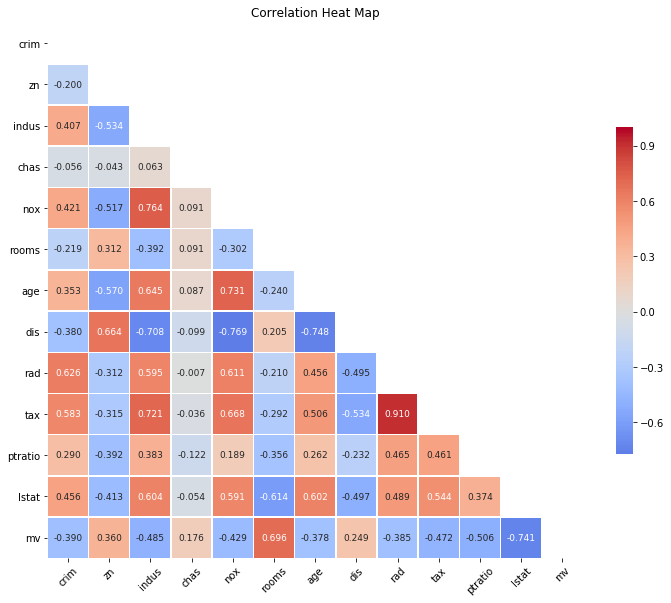

In [7]:
# correlation heat map setup for seaborn
def corr_chart(df_corr):
    corr=df_corr.corr()
    #screen top half to get a triangle
    top = np.zeros_like(corr, dtype=np.bool)
    top[np.triu_indices_from(top)] = True
    fig=plt.figure()
    fig, ax = plt.subplots(figsize=(12,12))
    sns.heatmap(corr, mask=top, cmap='coolwarm', 
        center = 0, square=True, 
        linewidths=.5, cbar_kws={'shrink':.5}, 
        annot = True, annot_kws={'size': 9}, fmt = '.3f')           
    plt.xticks(rotation=45) # rotate variable labels on columns (x axis)
    plt.yticks(rotation=0) # use horizontal variable labels on rows (y axis)
    plt.title('Correlation Heat Map')   
    plt.savefig('plot-corr-map.pdf', 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)      

np.set_printoptions(precision=3)

# examine intercorrelations among housing variables
corr_chart(df_corr = boston) 

- the highest correlation appears to be with rad and tax variables
- other variables with high, positive correlation include:
  - nox, indus
  - tax, indus
  - age, nox
- other variables with high, negative correlation include:
  - age, dis
  - nox, dis
  - indus, dis
  - lstat, mv
   

In [8]:
#sort variables correlated with median value
corr_matrix = boston.corr()
corr_matrix["mv"].sort_values( ascending = False)

mv         1.000000
rooms      0.696304
zn         0.360386
dis        0.249315
chas       0.175663
age       -0.377999
rad       -0.384766
crim      -0.389582
nox       -0.429300
tax       -0.471979
indus     -0.484754
ptratio   -0.505655
lstat     -0.740836
Name: mv, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F47FB37EB8>,
      dtype=object)

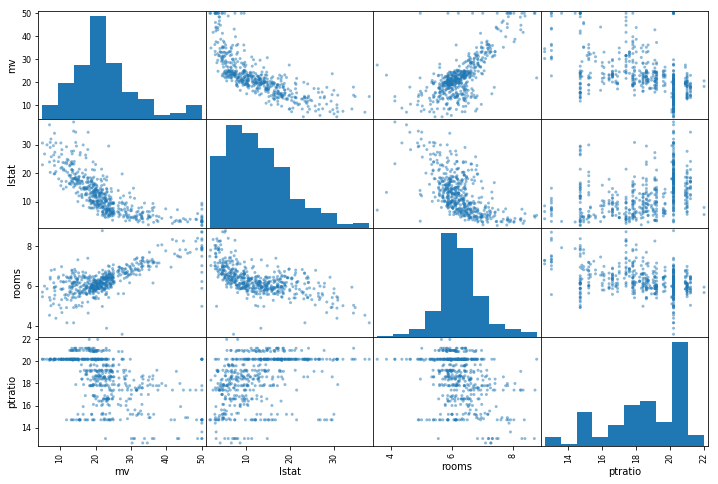

In [9]:
#scatterplots of top three highly correlated values with median value
attributes = ["mv", "lstat", "rooms", "ptratio"] 
scatter_matrix(boston[ attributes], figsize =( 12, 8))



In [10]:
# set up preliminary data 
# the first column is the median housing value or y 
# the remaining columns are the explanatory variables or X
prelim_model_data = np.array([boston.mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

# preliminary data before standardization
print('\nData dimensions:', prelim_model_data.shape)


Data dimensions: (506, 13)


In [11]:
# standard scores for the columns along axis 0
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(scaler.fit(prelim_model_data))

# display standardization constants 
print(scaler.mean_)
print(scaler.scale_)


StandardScaler(copy=True, with_mean=True, with_std=True)
[2.253e+01 3.614e+00 1.136e+01 1.114e+01 6.917e-02 5.547e-01 6.285e+00
 6.857e+01 3.795e+00 9.549e+00 4.082e+02 1.846e+01 1.265e+01]
[9.173e+00 8.593e+00 2.330e+01 6.854e+00 2.537e-01 1.158e-01 7.019e-01
 2.812e+01 2.104e+00 8.699e+00 1.684e+02 2.163e+00 7.134e+00]


In [12]:
# the model data will be standardized form of preliminary model data
model_data = scaler.fit_transform(prelim_model_data)

In [13]:
# dimensions in standardized units of measure
print('\nDimensions for model_data:', model_data.shape)


Dimensions for model_data: (506, 13)


In [14]:
# Code from evaluate-regression-methods-v001.py
# running Linear, Ridge, Lasso, and ElasticNet regressioon models
# normalize=False due to previous standardization
names = ['Linear_Regression', 'Ridge_Regression', 'Lasso_Regression', 
          'ElasticNet_Regression'] 

regressors = [LinearRegression(fit_intercept = SET_FIT_INTERCEPT), 
               Ridge(alpha = 1, solver = 'cholesky',
                     fit_intercept = SET_FIT_INTERCEPT, 
                     normalize = False, 
                     random_state = RANDOM_SEED),
               Lasso(alpha = 0.1, max_iter=10000, tol=0.01, 
                     fit_intercept = SET_FIT_INTERCEPT, 
                     random_state = RANDOM_SEED),
               ElasticNet(alpha = 0.1, l1_ratio = 0.5, 
                          max_iter=10000, tol=0.01, 
                          fit_intercept = SET_FIT_INTERCEPT, 
                          normalize = False, 
                          random_state = RANDOM_SEED)]

In [15]:
# set up numpy array for storing results
cv_results = np.zeros((N_FOLDS, len(names)))

In [16]:
# K fold splitting process
kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

In [17]:
# check the splitting process 
# Code from evaluate-regression-methods-v001.py
index_for_fold = 0  
for train_index, test_index in kf.split(model_data):
    print('\nFold index:', index_for_fold,
          '------------------------------------------')
    # Split X and y variables into training and test datasets
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]  

    #Display shape
    print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
    print('X_train:', X_train.shape)
    print('X_test:',X_test.shape)
    print('y_train:', y_train.shape)
    print('y_test:',y_test.shape)
    
    index_for_method = 0  # initialize
    for name, reg_model in zip(names, regressors):
        print('\nRegression model evaluation for:', name)
        print('  Scikit Learn method:', reg_model)
        reg_model.fit(X_train, y_train)  # fit on the train set for this fold
        print('Fitted regression intercept:', reg_model.intercept_)
        print('Fitted regression coefficients:', reg_model.coef_)
 
        # evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        print('Coefficient of determination (R-squared):',
              r2_score(y_test, y_test_predict))
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        print(reg_model.get_params(deep=True))
        print('Root mean-squared error:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

#create dataframe for results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names


Fold index: 0 ------------------------------------------

Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (455, 12)
X_test: (51, 12)
y_train: (455,)
y_test: (51,)

Regression model evaluation for: Linear_Regression
  Scikit Learn method: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Fitted regression intercept: -0.005032049293645764
Fitted regression coefficients: [-0.111  0.136  0.014  0.079 -0.238  0.268  0.007 -0.371  0.27  -0.232
 -0.215 -0.455]
Coefficient of determination (R-squared): 0.7650752349379009
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
Root mean-squared error: 0.3080338355432656

Regression model evaluation for: Ridge_Regression
  Scikit Learn method: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='cholesky', tol=0.001)
Fitted regression intercept: -0.004773620761078949
Fitted regression coefficients: [-

In [62]:
# Split X and y variables into training and test datasets
X_train = model_data[train_index, 1:model_data.shape[1]]
X_test = model_data[test_index, 1:model_data.shape[1]]
y_train = model_data[train_index, 0]
y_test = model_data[test_index, 0]  

#Display shape
print('\nShape of input data for this fold:',
          '\nData Set: (Observations, Variables)')
print('X_train:', X_train.shape)
print('X_test:',X_test.shape)
print('y_train:', y_train.shape)
print('y_test:',y_test.shape)


Shape of input data for this fold: 
Data Set: (Observations, Variables)
X_train: (456, 12)
X_test: (50, 12)
y_train: (456,)
y_test: (50,)


In [63]:
index_for_method = 0  # initialize
for name, reg_model in zip(names, regressors):
        print('\nRegression model evaluation for:', name)
        print('  Scikit Learn method:', reg_model)
        reg_model.fit(X_train, y_train)  # fit on the train set for this fold
        print('Fitted regression intercept:', reg_model.intercept_)
        print('Fitted regression coefficients:', reg_model.coef_)
 
        # evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
        print('Coefficient of determination (R-squared):',
              r2_score(y_test, y_test_predict))
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
        print(reg_model.get_params(deep=True))
        print('Root mean-squared error:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
index_for_fold += 1

#create dataframe for results
cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names




Regression model evaluation for: Linear_Regression
  Scikit Learn method: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Fitted regression intercept: -0.004165299014140228
Fitted regression coefficients: [-0.107  0.131  0.013  0.076 -0.226  0.28   0.042 -0.336  0.326 -0.309
 -0.206 -0.452]
Coefficient of determination (R-squared): 0.477957357260997
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}
Root mean-squared error: 0.3331377635873666

Regression model evaluation for: Ridge_Regression
  Scikit Learn method: Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=1, solver='cholesky', tol=0.001)
Fitted regression intercept: -0.004046984711110133
Fitted regression coefficients: [-0.106  0.129  0.01   0.076 -0.223  0.281  0.04  -0.333  0.313 -0.296
 -0.205 -0.45 ]
Coefficient of determination (R-squared): 0.48862051999665757
{'alpha': 1, 'copy_X': True, 'fit_intercept': True,

In [18]:
# Comparison of models
# Code from evaluate-regression-methods-v001.py
print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')     
print(cv_results_df.mean())   



----------------------------------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression        0.561940
Ridge_Regression         0.560511
Lasso_Regression         0.587381
ElasticNet_Regression    0.568084
dtype: float64


RMSE is a good measure for how accurately the models are predicting the median value of a house in Boston. Lower values generally indicate a better fit of the model because RMSE is measuring how close the observed data points are to the model's predicted values. In this instance, all models  developed - Linear Regression, Ridge Regression, Lasso Regression, and Elastic Net Regression - have fairly close RMSE values. However, the model using Elastic Net regrssion appears to be a better model due to the lowest RMSE value (.030119) of the any models evaluated. I would recommend that management deploy the Elastic Net Regression in the future. 